<a href="https://colab.research.google.com/github/Minyst/ML_DL_Portfolio_KR/blob/main/AI%20Cover/2_Audio_Slicer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
!pip install -q librosa
!pip install -q soundfile

In [ ]:
from __future__ import unicode_literals
import os
import sys
import numpy as np
import librosa
import soundfile
from tqdm import tqdm

## Slicer

In [ ]:
def get_rms(
    y,
    *,
    frame_length=2048,
    hop_length=512,
    pad_mode="constant",
):
    padding = (int(frame_length // 2), int(frame_length // 2))
    y = np.pad(y, padding, mode=pad_mode)

    axis = -1
    # put our new within-frame axis at the end for now
    out_strides = y.strides + tuple([y.strides[axis]])
    # Reduce the shape on the framing axis
    x_shape_trimmed = list(y.shape)
    x_shape_trimmed[axis] -= frame_length - 1
    out_shape = tuple(x_shape_trimmed) + tuple([frame_length])
    xw = np.lib.stride_tricks.as_strided(
        y, shape=out_shape, strides=out_strides
    )
    if axis < 0:
        target_axis = axis - 1
    else:
        target_axis = axis + 1
    xw = np.moveaxis(xw, -1, target_axis)
    # Downsample along the target axis
    slices = [slice(None)] * xw.ndim
    slices[axis] = slice(0, None, hop_length)
    x = xw[tuple(slices)]

    # Calculate power
    power = np.mean(np.abs(x) ** 2, axis=-2, keepdims=True)

    return np.sqrt(power)


class Slicer:
    def __init__(self,
                 sr: int,
                 threshold: float = -40.,
                 min_length: int = 5000,
                 min_interval: int = 300,
                 hop_size: int = 20,
                 max_sil_kept: int = 5000):
        if not min_length >= min_interval >= hop_size:
            raise ValueError('The following condition must be satisfied: min_length >= min_interval >= hop_size')
        if not max_sil_kept >= hop_size:
            raise ValueError('The following condition must be satisfied: max_sil_kept >= hop_size')
        min_interval = sr * min_interval / 1000
        self.threshold = 10 ** (threshold / 20.)
        self.hop_size = round(sr * hop_size / 1000)
        self.win_size = min(round(min_interval), 4 * self.hop_size)
        self.min_length = round(sr * min_length / 1000 / self.hop_size)
        self.min_interval = round(min_interval / self.hop_size)
        self.max_sil_kept = round(sr * max_sil_kept / 1000 / self.hop_size)

    def _apply_slice(self, waveform, begin, end):
        if len(waveform.shape) > 1:
            return waveform[:, begin * self.hop_size: min(waveform.shape[1], end * self.hop_size)]
        else:
            return waveform[begin * self.hop_size: min(waveform.shape[0], end * self.hop_size)]

    def slice(self, waveform):
        if len(waveform.shape) > 1:
            samples = waveform.mean(axis=0)
        else:
            samples = waveform
        if samples.shape[0] <= self.min_length:
            return [waveform]
        rms_list = get_rms(y=samples, frame_length=self.win_size, hop_length=self.hop_size).squeeze(0)
        sil_tags = []
        silence_start = None
        clip_start = 0
        for i, rms in enumerate(rms_list):
            # Keep looping while frame is silent.
            if rms < self.threshold:
                # Record start of silent frames.
                if silence_start is None:
                    silence_start = i
                continue
            # Keep looping while frame is not silent and silence start has not been recorded.
            if silence_start is None:
                continue
            # Clear recorded silence start if interval is not enough or clip is too short
            is_leading_silence = silence_start == 0 and i > self.max_sil_kept
            need_slice_middle = i - silence_start >= self.min_interval and i - clip_start >= self.min_length
            if not is_leading_silence and not need_slice_middle:
                silence_start = None
                continue
            # Need slicing. Record the range of silent frames to be removed.
            if i - silence_start <= self.max_sil_kept:
                pos = rms_list[silence_start: i + 1].argmin() + silence_start
                if silence_start == 0:
                    sil_tags.append((0, pos))
                else:
                    sil_tags.append((pos, pos))
                clip_start = pos
            elif i - silence_start <= self.max_sil_kept * 2:
                pos = rms_list[i - self.max_sil_kept: silence_start + self.max_sil_kept + 1].argmin()
                pos += i - self.max_sil_kept
                pos_l = rms_list[silence_start: silence_start + self.max_sil_kept + 1].argmin() + silence_start
                pos_r = rms_list[i - self.max_sil_kept: i + 1].argmin() + i - self.max_sil_kept
                if silence_start == 0:
                    sil_tags.append((0, pos_r))
                    clip_start = pos_r
                else:
                    sil_tags.append((min(pos_l, pos), max(pos_r, pos)))
                    clip_start = max(pos_r, pos)
            else:
                pos_l = rms_list[silence_start: silence_start + self.max_sil_kept + 1].argmin() + silence_start
                pos_r = rms_list[i - self.max_sil_kept: i + 1].argmin() + i - self.max_sil_kept
                if silence_start == 0:
                    sil_tags.append((0, pos_r))
                else:
                    sil_tags.append((pos_l, pos_r))
                clip_start = pos_r
            silence_start = None
        # Deal with trailing silence.
        total_frames = rms_list.shape[0]
        if silence_start is not None and total_frames - silence_start >= self.min_interval:
            silence_end = min(total_frames, silence_start + self.max_sil_kept)
            pos = rms_list[silence_start: silence_end + 1].argmin() + silence_start
            sil_tags.append((pos, total_frames + 1))
        # Apply and return slices.
        if len(sil_tags) == 0:
            return [waveform]
        else:
            chunks = []
            if sil_tags[0][0] > 0:
                chunks.append(self._apply_slice(waveform, 0, sil_tags[0][0]))
            for i in range(len(sil_tags) - 1):
                chunks.append(self._apply_slice(waveform, sil_tags[i][1], sil_tags[i + 1][0]))
            if sil_tags[-1][1] < total_frames:
                chunks.append(self._apply_slice(waveform, sil_tags[-1][1], total_frames))
            return chunks

sr

    Sampling rate of the input audio.

db_threshold

    The RMS threshold presented in dB. Areas where all RMS values are below this threshold will be regarded as silence. Increase this value if your audio is noisy. Defaults to -40.

min_length

    The minimum length required for each sliced audio clip, presented in milliseconds. Defaults to 5000.

min_interval

    The minimum length for a silence part to be sliced, presented in milliseconds. Set this value smaller if your audio contains only short breaks. The smaller this value is, the more sliced audio clips this script is likely to generate. Note that this value must be smaller than min_length and larger than hop_size. Defaults to 300.

hop_size

    Length of each RMS frame, presented in milliseconds. Increasing this value will increase the precision of slicing, but will slow down the process. Defaults to 10.

max_silence_kept

    The maximum silence length kept around the sliced audio, presented in milliseconds. Adjust this value according to your needs. Note that setting this value does not mean that silence parts in the sliced audio have exactly the given length. The algorithm will search for the best position to slice, as described above. Defaults to 1000.

## Apply


In [ ]:
base_dir = "/content/drive/MyDrive/AICover"
save_dir = f'{base_dir}/PHS/slice'
os.makedirs(save_dir, exist_ok=True)

In [ ]:
singer_name = "PHS"
collect_chunks = []
for music in ["추억은사랑을닮아", "야생화", "눈의꽃", "Gift", "동경"]:
    vocals_path = f'/content/drive/MyDrive/AICover/{singer_name}/{music}/vocals.wav'
    audio, sr = librosa.load(vocals_path, sr=None, mono=False)
    slicer = Slicer(
    sr=sr,
    threshold=-40,
    min_length=5000,
    min_interval=300,
    hop_size=10,
    max_sil_kept=500)
    chunks = slicer.slice(audio)
    collect_chunks.extend(chunks)

for chunk in tqdm(collect_chunks):
    if len(chunk.shape) > 1:
        chunk = chunk.T  # Swap axes if the audio is stereo.
    idx = len(os.listdir(save_dir))
    soundfile.write(f'{save_dir}/split_{idx}.wav', chunk, sr)

100%|██████████| 90/90 [00:05<00:00, 15.79it/s]


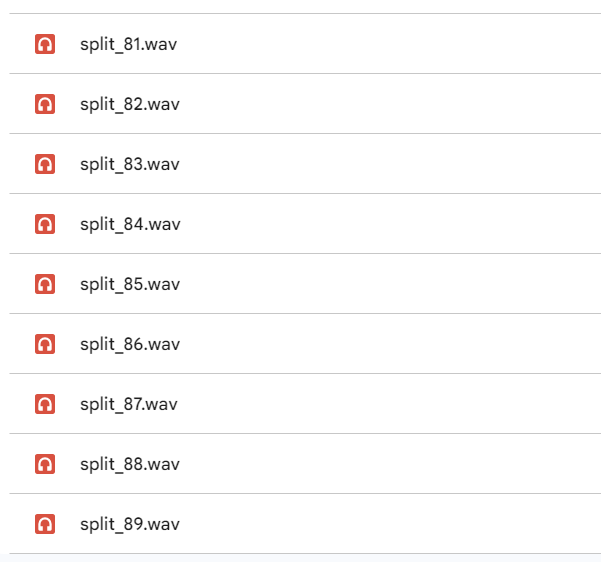